# FIN-525 Financial Big Data Project

## Importation

In [1]:
#Working
import pandas as pd
import numpy as np
from benfordslaw import benfordslaw

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

#DB
import wrds
import yfinance as yf
from sec_edgar_downloader import Downloader

#Utils
from tqdm import tqdm
from time import time
import pickle as pkl
import os



## Constants

In [2]:
RANDOM_SEED = 7
DATA_DIR = "../data/"
INTERM_DIR = '../compiled_data'

## Data Query

### WRDS

In [ ]:
db = wrds.Connection(wrds_username='debabech', wrds_passeword='Electro1004$')
db.create_pgpass_file()
permcos = db.get_table(library='crsp', table='stocknames')[
    ["permco", "ticker"]]

### EDGAR

In [22]:
ticker = "Apple"

path = os.path.join(DATA_DIR+"edgar/", ticker+"/py_10-Q")
os.mkdir(path)
dl = Downloader(DATA_DIR+"edgar/" +ticker+"/py_10-Q")

# Get all 13F filings for Apple
info = dl.get("10-Q", ticker) # , after="2017-01-01", before="2017-03-25") # "13F-NT" 13F-HR

Skipping filing detail download for '0001005150-00-001591' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001084681/000100515000001591/0001.txt.
Skipping filing detail download for '0001000096-00-000515' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000934330/000100009600000515/0001.txt.
Skipping filing detail download for '0001005150-00-001153' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001084681/000100515000001153/0001.txt.


In [11]:
from xml.dom import minidom
# parse an xml file by name
file = minidom.parse('/Users/ade/Desktop/Github/BD_Finance/data/edgar/Apple/13F-HR/sec-edgar-filings/APPLE/13F-HR/0001012975-20-000405/filing-details.xml')

#use getElementsByTagName() to get tag
models = file.getElementsByTagName('model')

# all items data
print('\nAll model data:')
for elem in models:
  print(elem.firstChild.data)


All model data:


### 10-Q test


In [21]:
import edgar
#install Python Edgar library
import pandas as pd

edgar.download_index('/Users/ade/Desktop/Github/BD_Finance/data/edgar/Apple/10-Q', 2018, "Amin amin.debabeche@epfl.ch", skip_all_present_except_last=False)

selectedcompany = 'Facebook'
selectedreport = '10-Q'

csv = pd.read_csv('/Users/ade/Desktop/Github/BD_Finance/data/edgar/Apple/10-Q/2019-QTR4.tsv', sep='\t',  lineterminator='\n', names=None) 

csv.columns.values[0] = 'Item'

companyreport = csv[(csv['Item'].str.contains(selectedcompany)) & (csv['Item'].str.contains(selectedreport))]

Filing = companyreport['Item'].str.split('|')
Filing = Filing.to_list()

for item in Filing[0]:
    
    if 'html' in item:
        report = item
        
url = 'https://www.sec.gov/Archives/' + report
#https://www.sec.gov/ix?doc=/Archives/edgar/data/1652044/000165204419000032/goog10-qq32019.htm

df = pd.read_html(url)
document_index = df[0]
document_index = document_index.dropna()

document_name = document_index[document_index['Description'].str.contains(selectedreport)]
document_name = document_name['Document'].str.split(' ')
document_name = document_name[0][0]

report_formatted = report.replace('-','').replace('index.html','')
url = 'https://www.sec.gov/Archives/' + report_formatted + '/' + document_name

HTTPError: HTTP Error 403: Forbidden

## Theory

In [28]:
# get_random_data

# This is a simple function which creates 1000 random values between 1 and 1000.

def get_random_data():  
    """
    Returns a list of 1000 numbers approximately
    following the uniform distribution NOT the
    Benford Distribution.
    """
    random_data = [0] * 1000
    random_data = list(map(lambda n: n + random.randint(1, 1000), random_data))
    return random_data

In [36]:
def ben_theoritical():  
    """
    Returns a list of 1000 numbers following
    the Benford's law Distribution.
    """
    results=[]
    
    for n in range(1,10):
        results.append(np.log10(n + 1) - np.log10(n))
    
    return results

Plotting

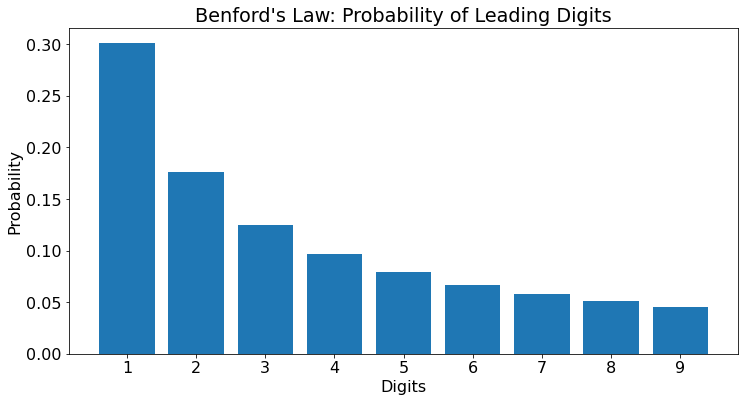

In [44]:
digit_probs = ben_theoritical()
digits = list(range(1,10))

plt.rc('font', size=16)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(digits, digit_probs)
plt.xticks(digits)
plt.xlabel('Digits')

plt.ylabel('Probability')
plt.title("Benford's Law: Probability of Leading Digits")
plt.show()


# Case Study

## Fibonacci Series

In [45]:
# Calculates and stores the first n = 1000 Fibonacci numbers
def fibonacci(n):
    fibs = [1, 1]
    for i in range(2, n + 1):
        fibs.append(fibs[i - 1] + fibs[i - 2])
    return fibs

fib_nums = fibonacci(1000)

# Calculate the number of leading digits for 1000 Fibonacci Numbers
def leading_digit_count(numbers):
    digit_dict = { 'digit': np.arange(1,10),
                   'prob' : np.zeros(9),
                   'count': np.zeros(9) }
    for num in numbers:
        first_digit = int(str(num)[:1])
        ind = np.where(digit_dict['digit'] == first_digit)
        digit_dict['count'][ind] =  digit_dict['count'][ind] +1 
    
    digit_dict['prob'] = digit_dict['count'] / len(numbers)
    
    return digit_dict

leading_digit_prob = leading_digit_count(fib_nums)

sse0 = np.sum((leading_digit_prob['prob'] - digit_probs) ** 2)

print('Sum of squared errors is ', sse0)


Sum of squared errors is  7.171471223186221e-06


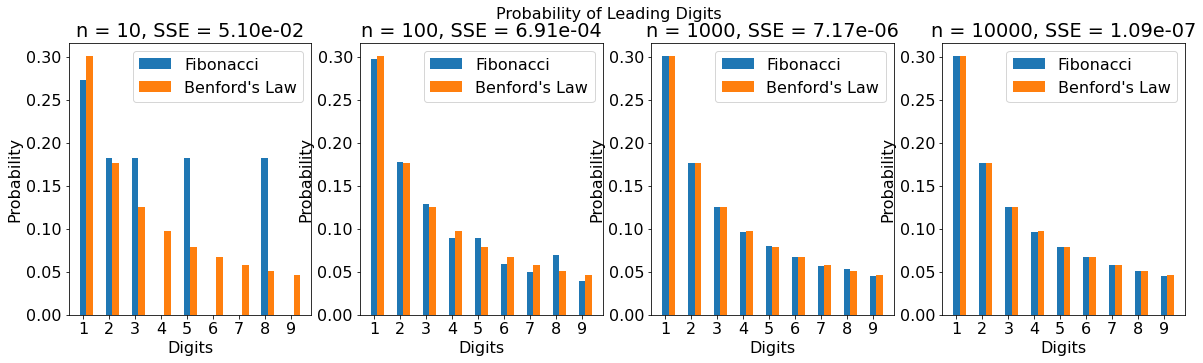

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

for i, ax in enumerate(axs):
    n = 10 ** (i + 1)
    fib_nums = fibonacci(n)
    leading_digit_prob = leading_digit_count(fib_nums)
    sse0 = np.sum((leading_digit_prob['prob'] - digit_probs) ** 2)
    
    ax.bar(leading_digit_prob['digit'], leading_digit_prob['prob'], width=0.25)
    new_digits = [e+0.25 for e in digits]
    ax.bar(new_digits, digit_probs, width = 0.25)
    
    ax.set_xticks(leading_digit_prob['digit'])
    ax.set_xlabel('Digits')
    ax.set_ylabel('Probability')
    ax.set_title(f'n = {n}, SSE = {sse0:.2e}')
    
    ax.legend(labels=['Fibonacci', "Benford's Law"])
    
plt.suptitle(f'Probability of Leading Digits', fontsize=16)
plt.show()


## US elections

[benfordslaw] >Import dataset [USA]
[ 5387 23618  1710 ...    16    21     0]
[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] No anomaly detected. P=0.422984, Tstat=8.10808


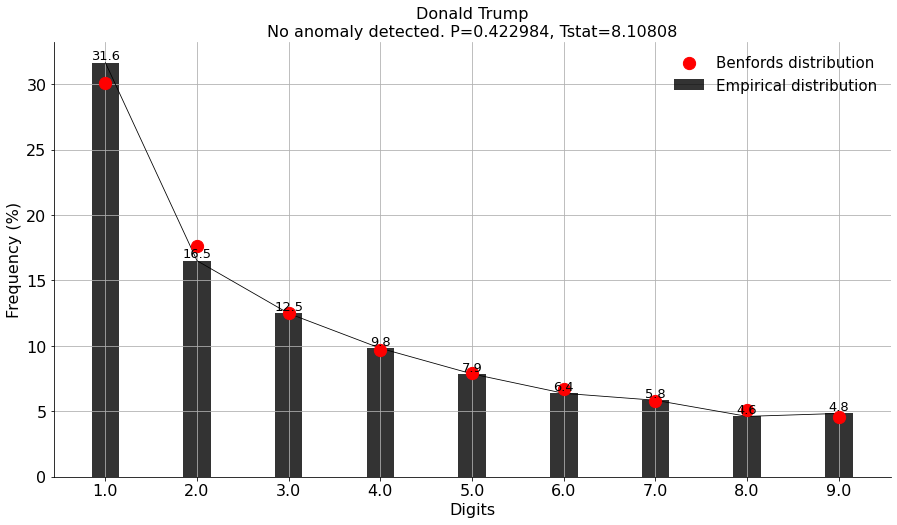

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Donald Trump\nNo anomaly detected. P=0.422984, Tstat=8.10808'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [68]:
# Initialize
bl = benfordslaw(alpha=0.05)

# Load elections example
df = bl.import_example(data='USA')

# Extract election information.
X = df['votes'].loc[df['candidate']=='Donald Trump'].values

# Print
print(X)
# array([ 5387, 23618,  1710, ...,    16,    21,     0], dtype=int64)

# Make fit
results = bl.fit(X)

# Plot
bl.plot(title='Donald Trump')


[benfordslaw] >Import dataset [USA]
[benfordslaw] >Analyzing digit position: [2]
[benfordslaw] >[ks] No anomaly detected. P=0.994458, Tstat=0.2


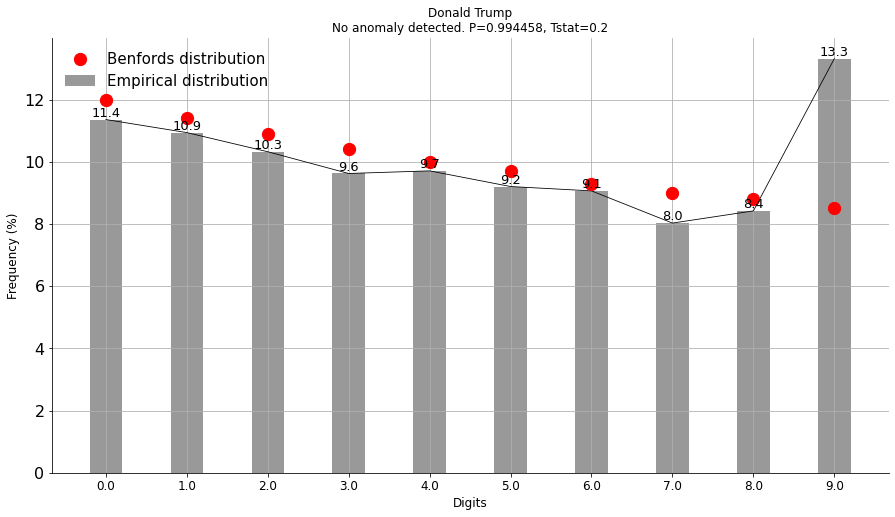

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Donald Trump\nNo anomaly detected. P=0.994458, Tstat=0.2'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [83]:
# ================== Second digit =================

# Initialize and set to analyze the second digit postion
bl = benfordslaw(pos=2, method="ks")
# USA example
df = bl.import_example(data='USA')
results = bl.fit(X)
# Plot
bl.plot(title='Donald Trump', barcolor=[0.5, 0.5, 0.5], fontsize=12, barwidth=0.4)

[benfordslaw] >Import dataset [USA]
[benfordslaw] >Analyzing digit position: [-2]
[benfordslaw] >[ks] No anomaly detected. P=0.994458, Tstat=0.2


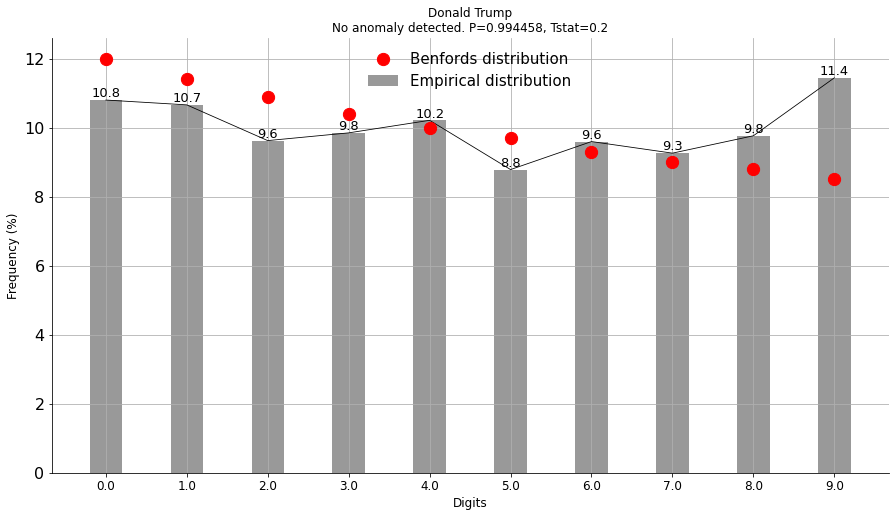

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Donald Trump\nNo anomaly detected. P=0.994458, Tstat=0.2'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [80]:
# ================== Second last digit =================

# Initialize and set to analyze the last postion
bl = benfordslaw(pos=-2, method='ks')
# USA example
df = bl.import_example(data='USA')
results = bl.fit(X)
# Plot
bl.plot(title='Donald Trump', barcolor=[0.5, 0.5, 0.5], fontsize=12, barwidth=0.4)

[benfordslaw] >Import dataset [USA]
[benfordslaw] >Analyzing digit position: [-1]
[benfordslaw] >[P_ensemble] Anomaly detected! P=2.55761e-304, Tstat=1411.21


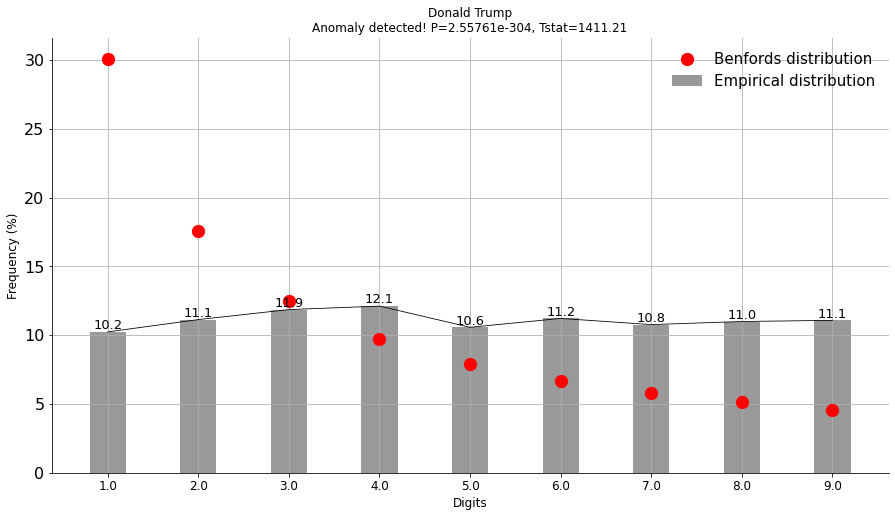

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Donald Trump\nAnomaly detected! P=2.55761e-304, Tstat=1411.21'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [82]:
# ================== Second last digit =================

# Initialize and set to analyze the last postion
bl = benfordslaw(pos=-1, method=None)
# USA example
df = bl.import_example(data='USA')
results = bl.fit(X)
# Plot
bl.plot(title='Donald Trump', barcolor=[0.5, 0.5, 0.5], fontsize=12, barwidth=0.4)

method : string, (Default: 'chi2').
            * 'chi2'
            * 'ks'
            * None (combined pvalues based fishers-method)

[benfordslaw] >Import dataset [USA]
[benfordslaw] >Analyzing digit position: [-1]
[benfordslaw] >[chi2] Anomaly detected! P=1.07833e-305, Tstat=1440.33


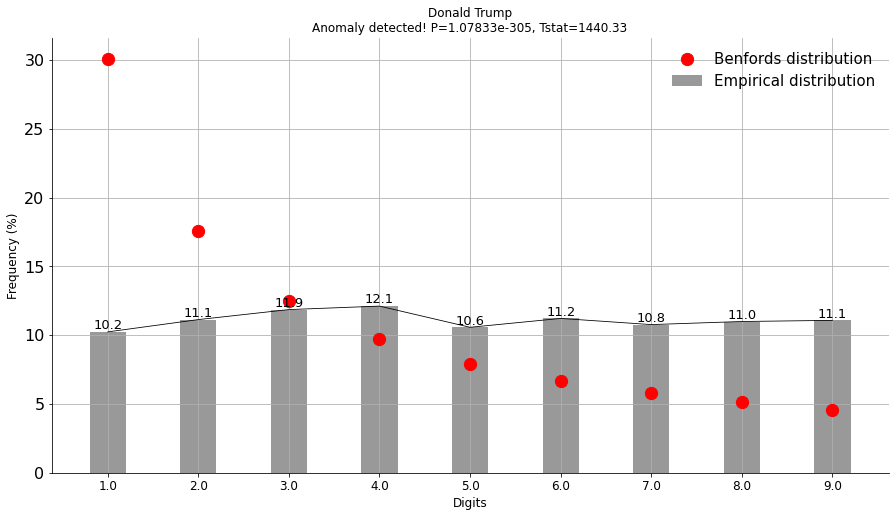

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Donald Trump\nAnomaly detected! P=1.07833e-305, Tstat=1440.33'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [75]:
# ================== Last digit =================

# Initialize and set to analyze the last postion
bl = benfordslaw(pos=-1)
# USA example
df = bl.import_example(data='USA')
results = bl.fit(X)
# Plot
bl.plot(title='Donald Trump', barcolor=[0.5, 0.5, 0.5], fontsize=12, barwidth=0.4)

## Financial performance

In [25]:
url = "/Users/ade/Desktop/Github/BD_Finance/data/edgar/Apple/py_10-Q/sec-edgar-filings/APPLE/10-Q/0000320193-17-000009/filing-details.html"
df = pd.read_html(url)

for item in df:
    BS = (item[0].str.contains('Retained') | item[0].str.contains('Total Assets'))
    if BS.any():
        Balance_Sheet = item
        

Balance_Sheet = Balance_Sheet.iloc[2:,[0,2,6]]

header = Balance_Sheet.iloc[0]
Balance_Sheet = Balance_Sheet[1:]

Balance_Sheet.columns = header


Balance_Sheet.columns.values[0] = 'Item'
Balance_Sheet = Balance_Sheet[Balance_Sheet['Item'].notna()]

Balance_Sheet[Balance_Sheet.columns[1:]] = Balance_Sheet[Balance_Sheet.columns[1:]].astype(str)
Balance_Sheet[Balance_Sheet.columns[1]] = Balance_Sheet[Balance_Sheet.columns[1]].map(lambda x: x.replace('(','-'))
Balance_Sheet[Balance_Sheet.columns[2]] = Balance_Sheet[Balance_Sheet.columns[2]].map(lambda x: x.replace('(','-'))

Balance_Sheet[Balance_Sheet.columns[1]] = Balance_Sheet[Balance_Sheet.columns[1]].map(lambda x: x.replace(',',''))
Balance_Sheet[Balance_Sheet.columns[2]] = Balance_Sheet[Balance_Sheet.columns[2]].map(lambda x: x.replace(',',''))

Balance_Sheet[Balance_Sheet.columns[1]] = Balance_Sheet[Balance_Sheet.columns[1]].map(lambda x: x.replace('—','0'))
Balance_Sheet[Balance_Sheet.columns[2]] = Balance_Sheet[Balance_Sheet.columns[2]].map(lambda x: x.replace('—','0'))



# Balance_Sheet[Balance_Sheet.columns[1:]] = Balance_Sheet[Balance_Sheet.columns[1:]].astype(float)

Balance_Sheet

2,Item,"JulyÂ 1, 2017","SeptemberÂ 24, 2016"
3,ASSETS:,ASSETS:,ASSETS:
4,Current assets:,Â,Â
5,Cash and cash equivalents,18571,20484
6,Short-term marketable securities,58188,46671
7,"Accounts receivable, less allowances of $55 an...",12399,15754
8,Inventories,3146,2132
9,Vendor non-trade receivables,10233,13545
10,Other current assets,10338,8283
11,Total current assets,112875,106869
12,Â,Â,Â
